Reference: [48] 特徴量選択のまとめ (EN: Summary of feature selection)

##### This is Japanese Web site

https://qiita.com/shimopino/items/5fee7504c7acf044a521#filter-method

In [ ]:
# Loading the library

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

## Basic library
import numpy as np
import pandas as pd
## Converters
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
## Predictor (Estimator)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
## Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
## Split data sets (training and test data)
from sklearn.model_selection import train_test_split
## Parameter adjustment
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
## Evaluation function
from sklearn.metrics import accuracy_score, f1_score


In [ ]:
# Mount the drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Read Data
emotion_category = 'group'
location = "/content/drive/MyDrive/05_workspace/01_msc_project/data/output/11_data_pre_processing_for_openpose/" + emotion_category +"/openpose_all_results_merged_without_NaN.csv"
df = pd.read_csv(location)
df.head()

,Unnamed: 0,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,emotion,videoname
0,0,1,562.779,102.411,0.907640,543.195,165.124,0.867135,492.306,165.034,0.827632,462.811,241.515,0.830692,480.476,257.061,0.805224,596.092,167.062,0.781668,611.726,264.998,0.723928,635.317,349.198,0.843380,551.012,323.804,0.637305,517.691,323.798,0.615599,525.578,464.856,0.750513,539.312,586.325,0.579356,584.318,323.762,...,0.113992,487.808,270.611,0.055322,494.123,273.919,0.069360,492.319,274.220,0.206929,490.214,272.716,0.285343,487.508,273.919,0.067824,499.235,270.310,0.244309,496.529,265.800,0.312649,495.326,259.786,0.151584,498.935,261.289,0.085853,502.242,263.394,0.251915,501.942,261.590,0.403513,501.040,255.876,0.522673,output_video6.csv,ambiguous,video01
1,1,2,560.860,102.402,0.910264,543.156,165.150,0.871095,492.276,165.048,0.836653,464.786,241.466,0.811072,482.415,257.075,0.810412,596.102,168.983,0.762419,611.733,263.029,0.725409,635.279,349.210,0.842287,547.087,323.752,0.657947,513.810,321.857,0.651405,523.634,466.768,0.770017,533.372,590.210,0.713921,580.397,321.862,...,0.038476,487.041,269.972,0.047497,489.723,279.505,0.048049,492.106,280.101,0.046241,493.596,275.632,0.030804,492.106,269.674,0.043908,498.958,268.184,0.030303,498.958,264.609,0.061021,498.660,258.651,0.044613,502.236,260.140,0.031777,504.023,261.332,0.046090,503.427,259.842,0.087379,501.640,256.267,0.135717,output_video6.csv,ambiguous,video01
2,2,3,560.798,102.359,0.923396,543.189,165.121,0.867678,492.280,164.998,0.836347,466.792,239.520,0.777852,484.372,257.105,0.800243,598.028,168.958,0.767903,611.772,261.073,0.747598,635.346,349.223,0.843892,549.014,321.848,0.650375,515.747,321.816,0.635799,519.620,462.940,0.716908,523.635,588.181,0.773207,582.329,321.813,...,0.197915,486.417,268.686,0.096429,492.773,274.754,0.082681,493.351,274.176,0.175678,491.617,275.331,0.133321,493.640,268.686,0.112211,499.418,270.420,0.254068,498.263,266.086,0.256436,496.240,258.862,0.279942,498.552,263.774,0.130395,502.886,264.063,0.261110,502.886,262.041,0.462578,502.597,256.840,0.604694,output_video6.csv,ambiguous,video01
3,3,4,558.914,102.321,0.930722,543.200,165.129,0.861878,492.282,163.164,0.839200,468.764,237.565,0.741477,480.519,257.102,0.796018,598.057,170.924,0.754375,613.656,266.908,0.731420,635.305,349.249,0.857972,543.250,325.707,0.655716,511.808,323.748,0.651776,511.861,464.780,0.754202,509.957,586.229,0.794806,578.438,325.699,...,0.221748,484.112,272.996,0.109295,480.963,283.587,0.103376,488.978,282.728,0.154196,489.837,278.435,0.166580,492.127,271.278,0.080522,496.993,272.710,0.126028,496.134,270.992,0.242762,494.703,262.118,0.215349,496.707,266.412,0.107075,501.859,266.126,0.230416,501.573,264.695,0.405128,500.714,259.828,0.508672,output_video6.csv,ambiguous,video01
4,4,5,558.904,100.481,0.932843,543.180,165.068,0.883817,492.251,163.128,0.860069,474.616,233.633,0.773151,480.515,257.167,0.812225,598.000,167.063,0.774960,611.772,264.970,0.755612,635.308,349.258,0.859445,541.320,323.730,0.680963,509.872,321.785,0.671638,509.816,462.805,0.792770,505.941,588.251,0.733877,576.452,323.727,...,0.154617,489.660,255.335,0.090149,487.794,264.133,0.098594,484.061,277.464,0.083608,486.994,279.597,0.079787,494.192,259.334,0.09

In [ ]:
df.shape

(413006, 416)

In [ ]:
class2idx = {
    'ambiguous':0,
    'negative':1,
    'neutral':2,
    'positive':3,
}

idx2class = {v: k for k, v in class2idx.items()}

df['emotion'].replace(class2idx, inplace=True)

In [ ]:
df.head()

,Unnamed: 0,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,emotion,videoname
0,0,1,562.779,102.411,0.907640,543.195,165.124,0.867135,492.306,165.034,0.827632,462.811,241.515,0.830692,480.476,257.061,0.805224,596.092,167.062,0.781668,611.726,264.998,0.723928,635.317,349.198,0.843380,551.012,323.804,0.637305,517.691,323.798,0.615599,525.578,464.856,0.750513,539.312,586.325,0.579356,584.318,323.762,...,0.113992,487.808,270.611,0.055322,494.123,273.919,0.069360,492.319,274.220,0.206929,490.214,272.716,0.285343,487.508,273.919,0.067824,499.235,270.310,0.244309,496.529,265.800,0.312649,495.326,259.786,0.151584,498.935,261.289,0.085853,502.242,263.394,0.251915,501.942,261.590,0.403513,501.040,255.876,0.522673,output_video6.csv,0,video01
1,1,2,560.860,102.402,0.910264,543.156,165.150,0.871095,492.276,165.048,0.836653,464.786,241.466,0.811072,482.415,257.075,0.810412,596.102,168.983,0.762419,611.733,263.029,0.725409,635.279,349.210,0.842287,547.087,323.752,0.657947,513.810,321.857,0.651405,523.634,466.768,0.770017,533.372,590.210,0.713921,580.397,321.862,...,0.038476,487.041,269.972,0.047497,489.723,279.505,0.048049,492.106,280.101,0.046241,493.596,275.632,0.030804,492.106,269.674,0.043908,498.958,268.184,0.030303,498.958,264.609,0.061021,498.660,258.651,0.044613,502.236,260.140,0.031777,504.023,261.332,0.046090,503.427,259.842,0.087379,501.640,256.267,0.135717,output_video6.csv,0,video01
2,2,3,560.798,102.359,0.923396,543.189,165.121,0.867678,492.280,164.998,0.836347,466.792,239.520,0.777852,484.372,257.105,0.800243,598.028,168.958,0.767903,611.772,261.073,0.747598,635.346,349.223,0.843892,549.014,321.848,0.650375,515.747,321.816,0.635799,519.620,462.940,0.716908,523.635,588.181,0.773207,582.329,321.813,...,0.197915,486.417,268.686,0.096429,492.773,274.754,0.082681,493.351,274.176,0.175678,491.617,275.331,0.133321,493.640,268.686,0.112211,499.418,270.420,0.254068,498.263,266.086,0.256436,496.240,258.862,0.279942,498.552,263.774,0.130395,502.886,264.063,0.261110,502.886,262.041,0.462578,502.597,256.840,0.604694,output_video6.csv,0,video01
3,3,4,558.914,102.321,0.930722,543.200,165.129,0.861878,492.282,163.164,0.839200,468.764,237.565,0.741477,480.519,257.102,0.796018,598.057,170.924,0.754375,613.656,266.908,0.731420,635.305,349.249,0.857972,543.250,325.707,0.655716,511.808,323.748,0.651776,511.861,464.780,0.754202,509.957,586.229,0.794806,578.438,325.699,...,0.221748,484.112,272.996,0.109295,480.963,283.587,0.103376,488.978,282.728,0.154196,489.837,278.435,0.166580,492.127,271.278,0.080522,496.993,272.710,0.126028,496.134,270.992,0.242762,494.703,262.118,0.215349,496.707,266.412,0.107075,501.859,266.126,0.230416,501.573,264.695,0.405128,500.714,259.828,0.508672,output_video6.csv,0,video01
4,4,5,558.904,100.481,0.932843,543.180,165.068,0.883817,492.251,163.128,0.860069,474.616,233.633,0.773151,480.515,257.167,0.812225,598.000,167.063,0.774960,611.772,264.970,0.755612,635.308,349.258,0.859445,541.320,323.730,0.680963,509.872,321.785,0.671638,509.816,462.805,0.792770,505.941,588.251,0.733877,576.452,323.727,...,0.154617,489.660,255.335,0.090149,487.794,264.133,0.098594,484.061,277.464,0.083608,486.994,279.597,0.079787,494.192,259.334,0.097416,491.793,265.466,0.312353,49

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Unnamed: 0', 'frame','filename','emotion','videoname'], axis=1),
    df['emotion'],
    test_size=0.2,
    random_state=2021
)

In [ ]:
# Remove data with a variance of 0 (all the same value)
sel = VarianceThreshold(threshold=0)
sel.fit(X_train)

# Returns a value of True for only the data held by get_support, False for all other data
print(sum(sel.get_support()))
# -> 411

411


In [ ]:
# Keep pandas as they are for the next process
X_train = X_train.loc[:, sel.get_support()]
X_test = X_test.loc[:, sel.get_support()]

In [ ]:
# Remove data with a variance of 10% (all the same value)
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train)

print(sum(sel.get_support()))
# -> 335

335


In [ ]:
# Keep pandas as they are for the next process
X_train = X_train.loc[:, sel.get_support()]
X_test = X_test.loc[:, sel.get_support()]

In [ ]:
# Delete data with correlations above 80%
threshold = 0.8

feat_corr = set()
corr_matrix = X_train.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            feat_name = corr_matrix.columns[i]
            feat_corr.add(feat_name)

print(len(set(feat_corr)))
# -> 313

X_train.drop(labels=feat_corr, axis='columns', inplace=True)
X_test.drop(labels=feat_corr, axis='columns', inplace=True)

print(len(X_train.columns))
# -> 22

313
22


In [ ]:
# The following data is the result of applying the previous Filter Method

print(X_train.shape)
# -> (3567, 4025)
print(X_test.shape)
# -> (892, 4025)

(330404, 22)
(82602, 22)


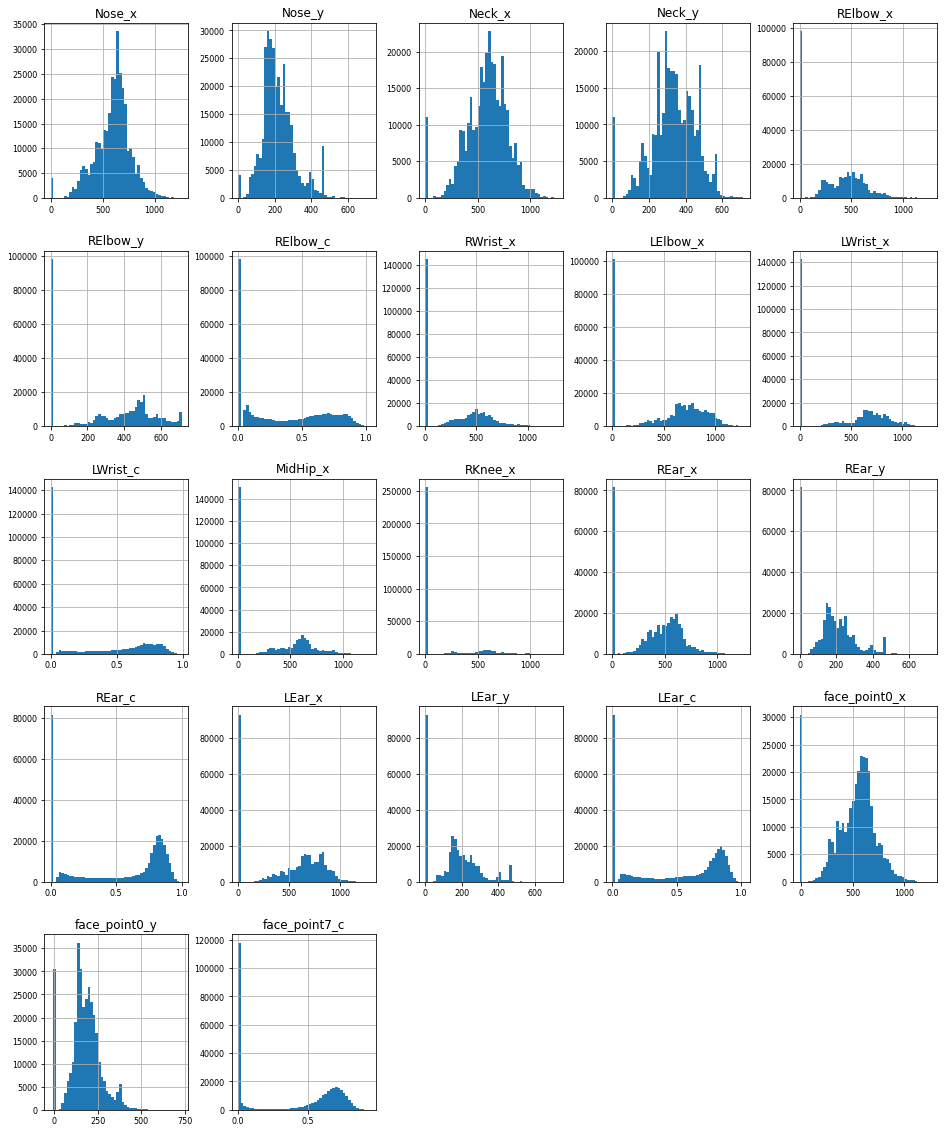

In [ ]:
X_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [ ]:
list(X_train.columns)

['Nose_x',
 'Nose_y',
 'Neck_x',
 'Neck_y',
 'RElbow_x',
 'RElbow_y',
 'RElbow_c',
 'RWrist_x',
 'LElbow_x',
 'LWrist_x',
 'LWrist_c',
 'MidHip_x',
 'RKnee_x',
 'REar_x',
 'REar_y',
 'REar_c',
 'LEar_x',
 'LEar_y',
 'LEar_c',
 'face_point0_x',
 'face_point0_y',
 'face_point7_c']

In [ ]:
# Building pipelines
## Features
features = ['Nose_x',
 'Nose_y',
 'Neck_x',
 'Neck_y',
 'RElbow_x',
 'RElbow_y',
 'RElbow_c',
 'RWrist_x',
 'LElbow_x',
 'LWrist_x',
 'LWrist_c',
 'MidHip_x',
 'RKnee_x',
 'REar_x',
 'REar_y',
 'REar_c',
 'LEar_x',
 'LEar_y',
 'LEar_c',
 'face_point0_x',
 'face_point0_y',
 'face_point7_c']

## Converter pipeline
### Pipeline definition
transformer = Pipeline(steps=[
    ("scaler", StandardScaler()) #standardize features
])

### Integration (feature -> transformer)
preprocessor = ColumnTransformer(transformers=[
    ("transform", transformer, features)
])

## Whole pipeline: converter pipeline -> predictor (estimator)
pipeline = Pipeline(steps=[
    ("preprocesser", preprocessor),      #converter pipeline
    ("classifier", RandomForestClassifier()) #predictor (estimator)
])

In [ ]:
# Building pipelines with training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Nose_x', 'Nose_y', 'Neck_x',
                                                   'Neck_y', 'RElbow_x',
                                                   'RElbow_y', 'RElbow_c',
                                                   'RWrist_x', 'LElbow_x',
                                                   'LWrist_x', 'LWrist_c',
                                                   'MidHip_x', 'RKnee_x',
                                                   'REar_x', 'REar_y', 'REar_c',
                                                   'LEar_x', 'LEar_y', 'LEar_c',
                                                   'face_point0_x',
                                                   'face

In [ ]:
# Accuracy verification with test data
y_test_pred = pipeline.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_test_pred))

accuracy: 0.9459940437277548


In [ ]:
# Setting up a grid search
param_grid = [
    {
        "preprocesser__transform__scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],       
        "classifier__n_estimators": [10, 100],
        "classifier": [RandomForestClassifier()]
    }
]
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=3, n_jobs=-1)

In [ ]:
# Run a grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesser',
                                        ColumnTransformer(transformers=[('transform',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Nose_x',
                                                                          'Nose_y',
                                                                          'Neck_x',
                                                                          'Neck_y',
                                                                          'RElbow_x',
                                                                          'RElbow_y',
                                                                          'RElbow_c',
                                  

In [ ]:
# Grid search results
print(grid_search.best_params_) #Optimal pipeline
print(grid_search.best_score_)  #Percentage of correct answers

{'classifier': RandomForestClassifier(), 'classifier__n_estimators': 100, 'preprocesser__transform__scaler': MinMaxScaler()}
0.9376430041119466


In [ ]:
# Accuracy verification with test data
y_test_pred = grid_search.predict(X_test)
print('accuracy:',accuracy_score(y_test, y_test_pred))

accuracy: 0.9460424687053582
